In [1]:
# =========================
# 1 — Imports, Config , Reproducibility
# =========================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from pathlib import Path
import joblib
import pickle
import random

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# Reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Paths

ROOT = Path(".").resolve()
DATA_DIR = ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"


# Selected stations 

MAIN_STATION = "M2"   # single buoy or main buoy in domain
GEN_STATION  = "M5"   # generalization buoy


# Sequence config — match preprocessing 

SEQ_LEN = 72
HORIZON = 6


# Auto-detect domain vs single-buoy training file

domain_file = PROCESSED_DIR / f"model_ready_{MAIN_STATION}_domain.npz"
single_file = PROCESSED_DIR / f"model_ready_{MAIN_STATION}.npz"

if domain_file.exists():
    MAIN_FILE = domain_file
elif single_file.exists():
    MAIN_FILE = single_file
else:
    raise FileNotFoundError(
        f"No processed training file found for {MAIN_STATION}. "
        f"Checked: {domain_file} and {single_file}"
    )

GEN_FILE = PROCESSED_DIR / f"model_ready_{GEN_STATION}.npz"
if not GEN_FILE.exists():
    raise FileNotFoundError(f"No processed generalization file found for {GEN_STATION}")


# Config printout

print(f"==Config==")
print(f"Main: {MAIN_STATION} ({'DOMAIN' if '_domain' in MAIN_FILE.name else 'SINGLE'})")
print(f"Gen: {GEN_STATION}")
print(f"SEQ_LEN={SEQ_LEN}, HORIZON={HORIZON}")
print(f"Main file: {MAIN_FILE.name}")
print(f"Gen file: {GEN_FILE.name}")


C:\Users\pesic\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


==Config==
Main: M2 (SINGLE)
Gen: M5
SEQ_LEN=72, HORIZON=6
Main file: model_ready_M2.npz
Gen file: model_ready_M5.npz


In [2]:
# =========================
# 2 — Load data, check class balance, pos_weight, focal-ready weights, feature alignment, balanced sampling
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

# Auto-detect main training file
domain_file = PROCESSED_DIR / f"model_ready_{MAIN_STATION}_domain.npz"
single_file = PROCESSED_DIR / f"model_ready_{MAIN_STATION}.npz"

if domain_file.exists():
    main_file = domain_file
elif single_file.exists():
    main_file = single_file
else:
    raise FileNotFoundError(
        f"No processed training file found for {MAIN_STATION}. "
        f"Checked: {domain_file} and {single_file}"
    )

# Generalization buoy file
gen_file = PROCESSED_DIR / f"model_ready_{GEN_STATION}.npz"
if not gen_file.exists():
    raise FileNotFoundError(f"No processed generalization file found for {GEN_STATION}")

print(f"MAIN file: {main_file.name} ({'DOMAIN' if '_domain' in main_file.name else 'SINGLE'})")
print(f"GEN  file: {gen_file.name}")
print(f"Using device: {DEVICE}")

# Load main buoy/domain splits
main_data = np.load(main_file, allow_pickle=True)
X_train = torch.tensor(main_data["X_train"], dtype=torch.float32)
y_train_cls = torch.tensor(main_data["y_train_cls"], dtype=torch.float32)
y_train_reg = torch.tensor(main_data["y_train_reg"], dtype=torch.float32)
dates_train = pd.to_datetime(main_data["dates_train"])

X_val = torch.tensor(main_data["X_val"], dtype=torch.float32)
y_val_cls = torch.tensor(main_data["y_val_cls"], dtype=torch.float32)
y_val_reg = torch.tensor(main_data["y_val_reg"], dtype=torch.float32)
dates_val = pd.to_datetime(main_data["dates_val"])

X_test = torch.tensor(main_data["X_test"], dtype=torch.float32)
y_test_cls = torch.tensor(main_data["y_test_cls"], dtype=torch.float32)
y_test_reg = torch.tensor(main_data["y_test_reg"], dtype=torch.float32)
dates_test = pd.to_datetime(main_data["dates_test"])

# Load generalization buoy
gen_data = np.load(gen_file, allow_pickle=True)
X_gen = torch.tensor(gen_data["X_gen"], dtype=torch.float32)
y_gen_cls = torch.tensor(gen_data["y_gen_cls"], dtype=torch.float32)
y_gen_reg = torch.tensor(gen_data["y_gen_reg"], dtype=torch.float32)
dates_gen = pd.to_datetime(gen_data["dates_gen"])

# Feature alignment check
feat_counts = {split: arr.shape[2] for split, arr in {
    "train": X_train, "val": X_val, "test": X_test, "gen": X_gen
}.items()}
if len(set(feat_counts.values())) != 1:
    raise ValueError(f"Feature dimension mismatch across splits: {feat_counts}")
input_dim = next(iter(feat_counts.values()))
print(f"\nFeature alignment confirmed — input_dim={input_dim}")

# Danger rate distribution
def danger_stats(name, y):
    rate = 100 * y.mean().item()
    print(f"{name:<6} — Danger%: {rate:5.2f} ({y.sum().item():.0f} danger / {len(y):.0f} total)")
    return rate

print("\n=== Danger Rate per Split ===")
train_rate = danger_stats("Train", y_train_cls)
val_rate   = danger_stats("Val",   y_val_cls)
test_rate  = danger_stats("Test",  y_test_cls)
gen_rate   = danger_stats("Gen",   y_gen_cls)

# Compute pos_weight for BCEWithLogitsLoss
num_pos = y_train_cls.sum().item()
num_neg = len(y_train_cls) - num_pos
pos_weight = torch.tensor(num_neg / num_pos, dtype=torch.float32).to(DEVICE)
print(f"\nComputed pos_weight for BCEWithLogitsLoss: {pos_weight:.4f}")

# Per-class weights
neg_frac = num_neg / len(y_train_cls)
pos_frac = num_pos / len(y_train_cls)
class_weights = torch.tensor([neg_frac, pos_frac], dtype=torch.float32).to(DEVICE)
print(f"Class weights (neg,pos) for focal/weighted CE: {class_weights.cpu().numpy()}")

# Balanced batch sampling
from torch.utils.data import WeightedRandomSampler

class_sample_counts = np.bincount(y_train_cls.int().numpy())
weights_per_class = 1. / class_sample_counts
sample_weights = [weights_per_class[int(label)] for label in y_train_cls]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train_cls, y_train_reg),
                           batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(TensorDataset(X_val,   y_val_cls,   y_val_reg),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(TensorDataset(X_test,  y_test_cls,  y_test_reg),  batch_size=BATCH_SIZE)
gen_loader   = DataLoader(TensorDataset(X_gen,   y_gen_cls,   y_gen_reg),   batch_size=BATCH_SIZE)

# Debugging

# Try to locate WVHT dynamically
try:
    feature_names = main_data["feature_names"] if "feature_names" in main_data else None
    if feature_names is not None and "WaveHeight_rel" in feature_names:
        waveheight_idx = feature_names.index("WaveHeight_rel")
    else:
        waveheight_idx = 4  # fallback
except Exception:
    waveheight_idx = 4

sample_indices = np.random.choice(len(X_train), size=5, replace=False)
for idx in sample_indices:
    wvht_input = X_train[idx, :, waveheight_idx].numpy()
    wvht_target = y_train_reg[idx].item()
    assert wvht_target not in wvht_input, f"Leakage detected at sample {idx}"
print("\nMulti-sample causality check passed (no target values in input windows)")

# Feature distribution check (first 3 )
def print_feature_stats(X, name):
    X_np = X.numpy().reshape(-1, X.shape[2])
    print(f"{name:<5} mean={X_np.mean(0)[:3]}, std={X_np.std(0)[:3]}")

print("\n=== Feature scaling sanity check ===")
print_feature_stats(X_train, "Train")
print_feature_stats(X_val,   "Val")
print_feature_stats(X_gen,   "Gen")


MAIN file: model_ready_M2.npz (SINGLE)
GEN  file: model_ready_M5.npz
Using device: cpu

Feature alignment confirmed — input_dim=47

=== Danger Rate per Split ===
Train  — Danger%:  9.71 (6254 danger / 64416 total)
Val    — Danger%:  6.71 (926 danger / 13804 total)
Test   — Danger%:  9.44 (1303 danger / 13804 total)
Gen    — Danger%:  8.05 (3082 danger / 38287 total)

Computed pos_weight for BCEWithLogitsLoss: 9.3000
Class weights (neg,pos) for focal/weighted CE: [0.9029123  0.09708768]

Multi-sample causality check passed (no target values in input windows)

=== Feature scaling sanity check ===
Train mean=[-1.0438162e-06 -5.1406886e-07  1.5796468e-06], std=[0.99639994 0.9977652  0.99684757]
Val   mean=[ 0.0195988  -0.05529954 -0.13030273], std=[0.8798268  0.85609573 0.87729937]
Gen   mean=[ 0.07241201  0.00997731 -0.05478799], std=[0.9671471 0.9489428 0.9258466]


In [3]:
# =========================
# Debugging — Overlap and Leakage 
# =========================

def date_overlap(name_a, dates_a, name_b, dates_b):
    overlap = pd.Series(dates_a).isin(pd.Series(dates_b)).sum()
    print(f"{name_a}–{name_b} overlap: {overlap} samples")
    return overlap

print("\n==Overlap==")
ov_train_val  = date_overlap("Train", dates_train, "Val",  dates_val)
ov_val_test   = date_overlap("Val",   dates_val,   "Test", dates_test)
ov_train_test = date_overlap("Train", dates_train, "Test", dates_test)

# Cross-check GEN buoy against main domain
ov_gen_train  = date_overlap("Gen", dates_gen, "Train", dates_train)
ov_gen_val    = date_overlap("Gen", dates_gen, "Val",   dates_val)
ov_gen_test   = date_overlap("Gen", dates_gen, "Test",  dates_test)

# Warnings
if any(x > 0 for x in [ov_train_val, ov_val_test, ov_train_test]):
    print(" Overlap detected between MAIN domain splits.")
else:
    print(" No overlaps in MAIN domain splits.")

if any(x > 0 for x in [ov_gen_train, ov_gen_val, ov_gen_test]):
    print(" Leakage: GEN buoy shares timestamps with MAIN domain")
else:
    print(" No date overlap (GEN buoy and MAIN domain splits). ")



==Overlap==
Train–Val overlap: 0 samples
Val–Test overlap: 0 samples
Train–Test overlap: 0 samples
Gen–Train overlap: 0 samples
Gen–Val overlap: 0 samples
Gen–Test overlap: 0 samples
 No overlaps in MAIN domain splits.
 No date overlap (GEN buoy and MAIN domain splits). 



=== Class Balance (pre-plot sanity check) ===
Train  — Danger%:  9.71 (6254 danger / 64416 total)
Val    — Danger%:  6.71 (926 danger / 13804 total)
Test   — Danger%:  9.44 (1303 danger / 13804 total)
Gen    — Danger%:  8.05 (3082 danger / 38287 total)

Feature dimension: input_dim=47 (matches preprocessing)


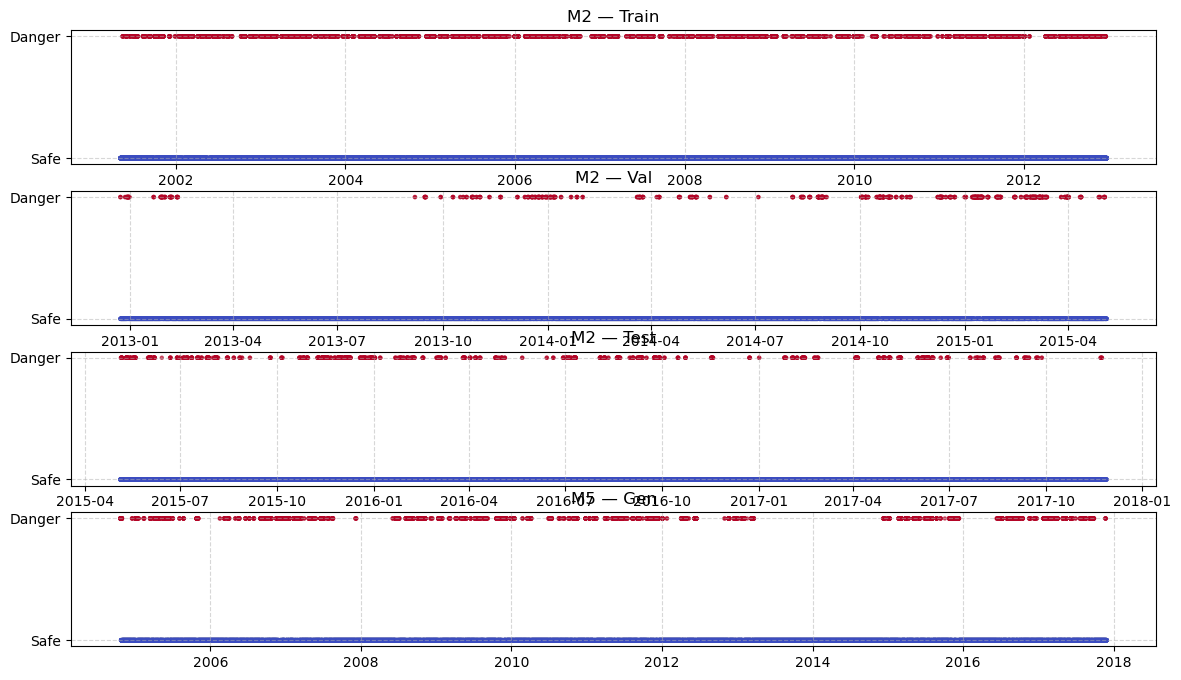

In [4]:
# =========================
# 3 — Danger Event Timeline Visualization + class balance debugging
# =========================
def plot_danger_timeline(dates, y_cls, title, ax=None):
    """Plot danger vs safe events over time for a given split."""
    # Ensure alignment
    min_len = min(len(dates), len(y_cls))
    if len(dates) != len(y_cls):
        print(f" {title}: Length mismatch -> trimming to {min_len}")
        dates, y_cls = dates[:min_len], y_cls[:min_len]

    # Ensure numpy arrays
    dates = np.array(dates)
    y_cls = np.array(y_cls)

    # Remove NaT/NaN dates
    mask = ~pd.isna(dates)
    dates = dates[mask]
    y_cls = y_cls[mask]

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2))

    scatter = ax.scatter(
        dates, y_cls,
        c=y_cls, cmap="coolwarm", s=5, alpha=0.6,
        vmin=0, vmax=1
    )
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Safe", "Danger"])
    ax.set_title(title, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

    return scatter

# Debug: class distribution per split ---
def print_class_balance(name, y):
    total = len(y)
    pos = int(y.sum())
    rate = 100 * pos / total
    print(f"{name:<6} — Danger%: {rate:5.2f} ({pos} danger / {total} total)")

print("\n=== Class Balance (pre-plot sanity check) ===")
print_class_balance("Train", y_train_cls)
print_class_balance("Val",   y_val_cls)
print_class_balance("Test",  y_test_cls)
print_class_balance("Gen",   y_gen_cls)

# Confirm feature dimension
print(f"\nFeature dimension: input_dim={X_train.shape[2]} (matches preprocessing)")

# Create timeline plots for all splits
fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharey=True)

plot_danger_timeline(dates_train, y_train_cls, f"{MAIN_STATION} — Train", axes[0])
plot_danger_timeline(dates_val,   y_val_cls,   f"{MAIN_STATION} — Val",   axes[1])
plot_danger_timeline(dates_test,  y_test_cls,  f"{MAIN_STATION} — Test",  axes[2])
scatter = plot_danger_timeline(dates_gen,      y_gen_cls,                f"{GEN_STATION} — Gen", axes[3])


In [5]:
# =========================
# DEBUG — Check for NaNs/Infs in data tensors
# =========================
def check_tensor(name, tensor):
    if not torch.isfinite(tensor).all():
        bad_count = (~torch.isfinite(tensor)).sum().item()
        print(f"{name}: Found {bad_count} non-finite values")
    else:
        print(f"{name}: No NaN/Inf detected")

# Check features
check_tensor("X_train", X_train)
check_tensor("X_val",   X_val)
check_tensor("X_test",  X_test)
check_tensor("X_gen",   X_gen)

# Check targets
check_tensor("y_train_cls", y_train_cls)
check_tensor("y_val_cls",   y_val_cls)
check_tensor("y_test_cls",  y_test_cls)
check_tensor("y_gen_cls",   y_gen_cls)

check_tensor("y_train_reg", y_train_reg)
check_tensor("y_val_reg",   y_val_reg)
check_tensor("y_test_reg",  y_test_reg)
check_tensor("y_gen_reg",   y_gen_reg)


X_train: No NaN/Inf detected
X_val: No NaN/Inf detected
X_test: No NaN/Inf detected
X_gen: No NaN/Inf detected
y_train_cls: No NaN/Inf detected
y_val_cls: No NaN/Inf detected
y_test_cls: No NaN/Inf detected
y_gen_cls: No NaN/Inf detected
y_train_reg: No NaN/Inf detected
y_val_reg: No NaN/Inf detected
y_test_reg: No NaN/Inf detected
y_gen_reg: No NaN/Inf detected


In [6]:
# =========================
# CELL 4 — Model Definition with Attention + Focal Loss
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# ---- Focal Loss implementation ----
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        loss = focal_weight * bce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# ---- Attention pooling ----
class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, gru_out):
        # gru_out: [B, T, H]
        attn_scores = torch.softmax(self.attn(gru_out), dim=1)  # [B, T, 1]
        context = torch.sum(attn_scores * gru_out, dim=1)       # [B, H]
        return context, attn_scores

# ---- GRU + Attention model ----
class GRU_Attn_DualHead(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.attn_pool = AttentionPooling(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.fc_reg = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)                    # [B, T, H]
        context, _ = self.attn_pool(gru_out)        # [B, H]
        context = self.dropout(context)
        cls_out = self.fc_cls(context).squeeze(-1)  # [B]
        reg_out = self.fc_reg(context).squeeze(-1)  # [B]
        return cls_out, reg_out

# ---- Instantiate model ----
INPUT_SIZE = X_train.shape[2]
model = GRU_Attn_DualHead(
    input_size=INPUT_SIZE, hidden_size=64, num_layers=2, dropout=0.3
).to(DEVICE)

# ---- Loss functions ----
print(f"\nUsing FocalLoss for classification (alpha=1, gamma=2)")
criterion_cls = FocalLoss(alpha=1, gamma=2)
criterion_reg = nn.MSELoss()

# ---- Optimizer & scheduler ----
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)



Using FocalLoss for classification (alpha=1, gamma=2)


In [7]:
# =========================
# 5 — Training loop with Val + Smoothed Gen AUC for early stopping (Gen-weighted) + Scheduler on Combined Score
# =========================

# Ensure reproducibility at training start
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

EPOCHS = 50
PATIENCE = 5
patience_counter = 0
best_combined_score = -np.inf
MODEL_PATH = PROCESSED_DIR / f"best_model_{MAIN_STATION}.pth"

ema_gen_auc = None  # EMA smoothed Gen AUC

print(f"\nTraining data Danger%: {100*y_train_cls.mean():.2f}, Validation data Danger%: {100*y_val_cls.mean():.2f}")

def evaluate(loader):
    all_probs, all_true, total_loss = [], [], 0
    with torch.no_grad():
        for xb, yb_cls, yb_reg in loader:
            xb, yb_cls, yb_reg = xb.to(DEVICE), yb_cls.to(DEVICE), yb_reg.to(DEVICE)
            logits_cls, preds_reg = model(xb)
            loss_cls = criterion_cls(logits_cls, yb_cls)
            loss_reg = criterion_reg(preds_reg, yb_reg)
            loss = loss_cls + 0.5 * loss_reg
            total_loss += loss.item() * xb.size(0)
            all_probs.extend(torch.sigmoid(logits_cls).cpu().numpy())
            all_true.extend(yb_cls.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    all_probs = np.array(all_probs)
    all_true = np.array(all_true)
    auc = roc_auc_score(all_true, all_probs)
    f1 = f1_score(all_true, (all_probs > 0.5).astype(int))
    return avg_loss, auc, f1

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False)
    for xb, yb_cls, yb_reg in train_bar:
        xb, yb_cls, yb_reg = xb.to(DEVICE), yb_cls.to(DEVICE), yb_reg.to(DEVICE)
        optimizer.zero_grad()
        logits_cls, preds_reg = model(xb)
        loss_cls = criterion_cls(logits_cls, yb_cls)
        loss_reg = criterion_reg(preds_reg, yb_reg)
        loss = loss_cls + 0.5 * loss_reg
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss /= len(train_loader.dataset)

    # Validation
    val_loss, val_auc, val_f1 = evaluate(val_loader)

    # Generalization with EMA smoothing 
    gen_loss, gen_auc_raw, gen_f1 = evaluate(gen_loader)
    if ema_gen_auc is None:
        ema_gen_auc = gen_auc_raw
    else:
        ema_gen_auc = 0.3 * gen_auc_raw + 0.7 * ema_gen_auc

    # Weighted combined score — more weight to Gen AUC
    combined_score = 0.4 * val_auc + 0.6 * ema_gen_auc

    # Step scheduler on combined score
    scheduler.step(combined_score)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f} | "
          f"Gen AUC (raw): {gen_auc_raw:.4f} | Gen AUC (EMA): {ema_gen_auc:.4f} | Gen F1: {gen_f1:.4f} | "
          f"Combined: {combined_score:.4f}")

    # Save best based on weighted combined score
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        torch.save({'model_state_dict': model.state_dict()}, MODEL_PATH)
        print(f"Saved new best model (Combined={combined_score:.4f}, Val AUC={val_auc:.4f}, Gen AUC EMA={ema_gen_auc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in combined score for {patience_counter} epoch(s)")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f" Early stopping triggered after {epoch} epochs. Best Combined Score={best_combined_score:.4f}")
        break

print(f"\nBest Combined Score: {best_combined_score:.4f}")



Training data Danger%: 9.71, Validation data Danger%: 6.71


Epoch 01 | Train Loss: 0.4913 | Val AUC: 0.9641 | Val F1: 0.6840 | Gen AUC (raw): 0.9530 | Gen AUC (EMA): 0.9530 | Gen F1: 0.5909 | Combined: 0.9574
Saved new best model (Combined=0.9574, Val AUC=0.9641, Gen AUC EMA=0.9530)


Epoch 02 | Train Loss: 0.2059 | Val AUC: 0.9785 | Val F1: 0.7165 | Gen AUC (raw): 0.9724 | Gen AUC (EMA): 0.9588 | Gen F1: 0.6708 | Combined: 0.9667
Saved new best model (Combined=0.9667, Val AUC=0.9785, Gen AUC EMA=0.9588)


Epoch 03 | Train Loss: 0.1795 | Val AUC: 0.9805 | Val F1: 0.7540 | Gen AUC (raw): 0.9738 | Gen AUC (EMA): 0.9633 | Gen F1: 0.7090 | Combined: 0.9702
Saved new best model (Combined=0.9702, Val AUC=0.9805, Gen AUC EMA=0.9633)


Epoch 04 | Train Loss: 0.1681 | Val AUC: 0.9810 | Val F1: 0.7343 | Gen AUC (raw): 0.9718 | Gen AUC (EMA): 0.9658 | Gen F1: 0.6517 | Combined: 0.9719
Saved new best model (Combined=0.9719, Val AUC=0.9810, Gen AUC EMA=0.9658)


Epoch 05 | Train Loss: 0.1609 | Val AUC: 0.9768 | Val F1: 0.7426 | Gen AUC (raw): 0.9673 | Gen AUC (EMA): 0.9663 | Gen F1: 0.6522 | Combined: 0.9705
No improvement in combined score for 1 epoch(s)


Epoch 06 | Train Loss: 0.1488 | Val AUC: 0.9670 | Val F1: 0.6823 | Gen AUC (raw): 0.9569 | Gen AUC (EMA): 0.9635 | Gen F1: 0.6505 | Combined: 0.9649
No improvement in combined score for 2 epoch(s)


Epoch 07 | Train Loss: 0.1392 | Val AUC: 0.9813 | Val F1: 0.7112 | Gen AUC (raw): 0.9724 | Gen AUC (EMA): 0.9661 | Gen F1: 0.6630 | Combined: 0.9722
Saved new best model (Combined=0.9722, Val AUC=0.9813, Gen AUC EMA=0.9661)


Epoch 08 | Train Loss: 0.1349 | Val AUC: 0.9765 | Val F1: 0.7223 | Gen AUC (raw): 0.9678 | Gen AUC (EMA): 0.9666 | Gen F1: 0.6607 | Combined: 0.9706
No improvement in combined score for 1 epoch(s)


Epoch 09 | Train Loss: 0.1282 | Val AUC: 0.9788 | Val F1: 0.7143 | Gen AUC (raw): 0.9721 | Gen AUC (EMA): 0.9683 | Gen F1: 0.6647 | Combined: 0.9725
Saved new best model (Combined=0.9725, Val AUC=0.9788, Gen AUC EMA=0.9683)


Epoch 10 | Train Loss: 0.1214 | Val AUC: 0.9711 | Val F1: 0.7214 | Gen AUC (raw): 0.9665 | Gen AUC (EMA): 0.9677 | Gen F1: 0.6572 | Combined: 0.9691
No improvement in combined score for 1 epoch(s)


Epoch 11 | Train Loss: 0.1169 | Val AUC: 0.9760 | Val F1: 0.7206 | Gen AUC (raw): 0.9712 | Gen AUC (EMA): 0.9688 | Gen F1: 0.6818 | Combined: 0.9717
No improvement in combined score for 2 epoch(s)


Epoch 12 | Train Loss: 0.1127 | Val AUC: 0.9673 | Val F1: 0.6836 | Gen AUC (raw): 0.9660 | Gen AUC (EMA): 0.9679 | Gen F1: 0.6552 | Combined: 0.9677
No improvement in combined score for 3 epoch(s)


Epoch 13 | Train Loss: 0.1115 | Val AUC: 0.9735 | Val F1: 0.7060 | Gen AUC (raw): 0.9680 | Gen AUC (EMA): 0.9680 | Gen F1: 0.6654 | Combined: 0.9702
No improvement in combined score for 4 epoch(s)


Epoch 14 | Train Loss: 0.0989 | Val AUC: 0.9684 | Val F1: 0.7151 | Gen AUC (raw): 0.9662 | Gen AUC (EMA): 0.9674 | Gen F1: 0.6808 | Combined: 0.9678
No improvement in combined score for 5 epoch(s)
 Early stopping triggered after 14 epochs. Best Combined Score=0.9725

Best Combined Score: 0.9725


In [8]:
# =========================
# 6 — Temperature Scaling Calibration
# =========================
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, x):
        logits_cls, preds_reg = self.model(x)
        return logits_cls / self.temperature, preds_reg

def _nll_loss(logits, labels):
    return nn.BCEWithLogitsLoss()(logits, labels)

def set_temperature(model, valid_loader):
    logits_list, labels_list = [], []
    with torch.no_grad():
        for xb, yb_cls, _ in valid_loader:
            xb, yb_cls = xb.to(DEVICE), yb_cls.to(DEVICE)
            logits, _ = model(xb)
            logits_list.append(logits)
            labels_list.append(yb_cls)
    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    temp_model = ModelWithTemperature(model).to(DEVICE)
    optimizer = torch.optim.LBFGS([temp_model.temperature], lr=0.01, max_iter=50)

    def eval_fn():
        optimizer.zero_grad()
        loss = _nll_loss(temp_model.model(X_val.to(DEVICE))[0] / temp_model.temperature, y_val_cls.to(DEVICE))
        loss.backward()
        return loss

    optimizer.step(eval_fn)
    print(f"Optimal temperature: {temp_model.temperature.item():.4f}")
    return temp_model

# Fit temperature on validation set
model = set_temperature(model, val_loader)


Optimal temperature: 0.7944


In [9]:
# =========================
# 7 - EVALUATION WITH MC DROPOUT + TEMPERATURE SCALING (Self-contained)
# =========================
from tqdm import tqdm
import numpy as np
import torch
from sklearn.metrics import (
    roc_auc_score, f1_score, mean_squared_error, mean_absolute_error, r2_score,
    precision_recall_curve, classification_report
)

def mc_dropout_predict(model, loader, mc_passes=20, desc="MC Dropout"):
    """
    Runs MC Dropout prediction for both classification and regression heads.
    Keeps dropout active during inference to produce stochastic predictions.
    """
    model.train()  # keep dropout active
    all_cls_probs, all_reg_preds = [], []

    for pass_idx in range(mc_passes):
        cls_probs, reg_preds = [], []
        with torch.no_grad():
            for xb, _, _ in tqdm(loader, desc=f"{desc} pass {pass_idx+1}/{mc_passes}", leave=False):
                xb = xb.to(DEVICE)
                logits_cls, preds_reg = model(xb)
                cls_probs.append(torch.sigmoid(logits_cls).detach().cpu().numpy())
                reg_preds.append(preds_reg.detach().cpu().numpy())
        all_cls_probs.append(np.concatenate(cls_probs, axis=0))
        all_reg_preds.append(np.concatenate(reg_preds, axis=0))

    mean_cls_probs = np.mean(all_cls_probs, axis=0)
    mean_reg_preds = np.mean(all_reg_preds, axis=0)
    return mean_cls_probs, mean_reg_preds

def regression_metrics(y_true, y_pred, name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<5} — RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.3f}")

# --- Ensure dropout active for MC sampling ---
model.train()

# --- Get MC Dropout predictions ---
val_probs, val_preds_reg   = mc_dropout_predict(model, val_loader,  mc_passes=20, desc="Val")
test_probs, test_preds_reg = mc_dropout_predict(model, test_loader, mc_passes=20, desc="Test")
gen_probs, gen_preds_reg   = mc_dropout_predict(model, gen_loader,  mc_passes=20, desc="Gen")

# --- Extract true labels ---
y_val_cls_np  = y_val_cls.numpy()
y_test_cls_np = y_test_cls.numpy()
y_gen_cls_np  = y_gen_cls.numpy()

y_val_reg_np  = y_val_reg.numpy()
y_test_reg_np = y_test_reg.numpy()
y_gen_reg_np  = y_gen_reg.numpy()

# --- ROC-AUC ---
val_auc  = roc_auc_score(y_val_cls_np,  val_probs)
test_auc = roc_auc_score(y_test_cls_np, test_probs)
gen_auc  = roc_auc_score(y_gen_cls_np,  gen_probs)
print(f"\nVal AUC={val_auc:.4f} | Test AUC={test_auc:.4f} | Gen AUC={gen_auc:.4f}")

# --- Threshold Calibration (Val-based) ---
prec, rec, thr = precision_recall_curve(y_val_cls_np, val_probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_thr = thr[np.argmax(f1_scores)]
print(f"Best threshold (Val) = {best_thr:.3f}")

# --- Apply threshold ---
val_preds_cls  = (val_probs  >= best_thr).astype(int)
test_preds_cls = (test_probs >= best_thr).astype(int)
gen_preds_cls  = (gen_probs  >= best_thr).astype(int)

# --- Classification Reports ---
print("\n=== Val Classification Report ===")
print(classification_report(y_val_cls_np, val_preds_cls, digits=3))
print("\n=== Test Classification Report ===")
print(classification_report(y_test_cls_np, test_preds_cls, digits=3))
print("\n=== Gen Classification Report ===")
print(classification_report(y_gen_cls_np, gen_preds_cls, digits=3))

# --- Regression Metrics ---
print("\n=== Regression Metrics ===")
regression_metrics(y_val_reg_np,  val_preds_reg,  "Val")
regression_metrics(y_test_reg_np, test_preds_reg, "Test")
regression_metrics(y_gen_reg_np,  gen_preds_reg,  "Gen")



Val AUC=0.9734 | Test AUC=0.9357 | Gen AUC=0.9694
Best threshold (Val) = 0.454

=== Val Classification Report ===
              precision    recall  f1-score   support

         0.0      0.982     0.976     0.979     12878
         1.0      0.696     0.757     0.725       926

    accuracy                          0.962     13804
   macro avg      0.839     0.867     0.852     13804
weighted avg      0.963     0.962     0.962     13804


=== Test Classification Report ===
              precision    recall  f1-score   support

         0.0      0.972     0.916     0.943     12501
         1.0      0.483     0.748     0.587      1303

    accuracy                          0.901     13804
   macro avg      0.727     0.832     0.765     13804
weighted avg      0.926     0.901     0.910     13804


=== Gen Classification Report ===
              precision    recall  f1-score   support

         0.0      0.987     0.939     0.963     35205
         1.0      0.555     0.864     0.676      30

In [23]:
import numpy as np

# Calculate bias (mean error) for regression
bias_results = {
    "Val":  np.mean(val_preds_reg - y_val_reg_np),
    "Test": np.mean(test_preds_reg - y_test_reg_np),
    "Gen":  np.mean(gen_preds_reg - y_gen_reg_np)
}

for split, bias in bias_results.items():
    print(f"{split} mean bias = {bias:.4f} m")


Val mean bias = 0.1228 m
Test mean bias = 0.4602 m
Gen mean bias = 0.0974 m


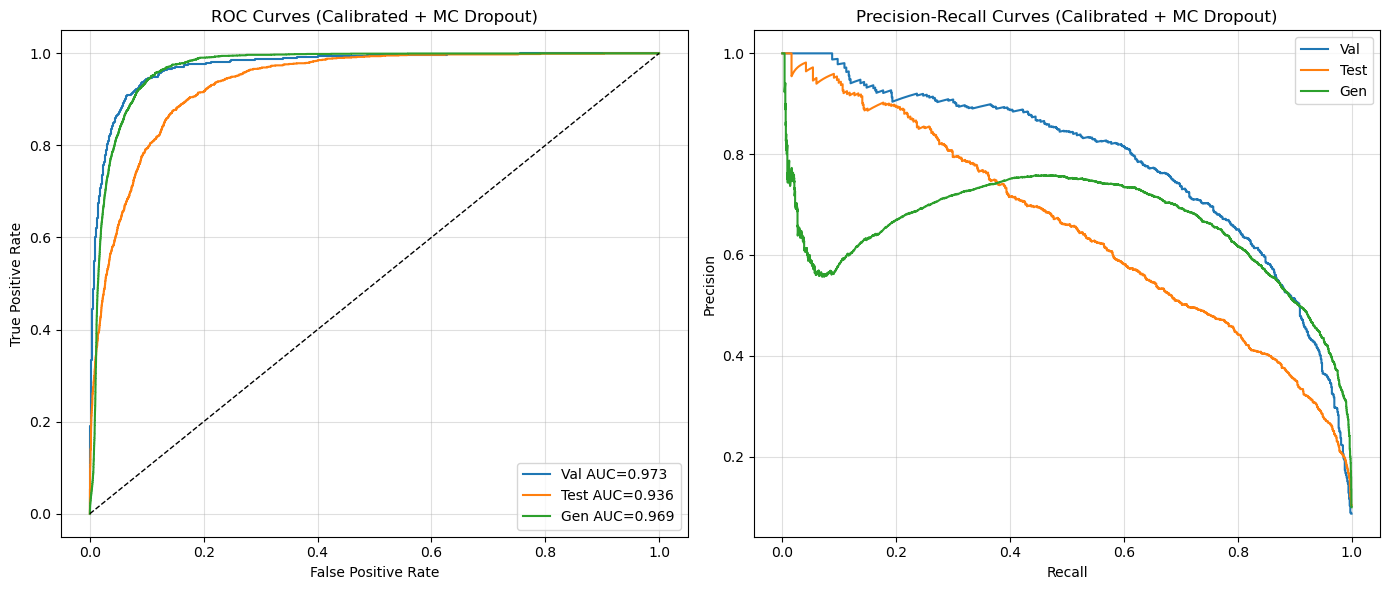

In [10]:
# =========================
# 8 - ROC & Precision-Recall Curves (Calibrated + MC Dropout)
# =========================
from sklearn.metrics import roc_curve, precision_recall_curve

results_mc = {
    "Val":  {"true": y_val_cls_np,  "probs": val_probs},
    "Test": {"true": y_test_cls_np, "probs": test_probs},
    "Gen":  {"true": y_gen_cls_np,  "probs": gen_probs},
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
for split, res in results_mc.items():
    fpr, tpr, _ = roc_curve(res["true"], res["probs"])
    auc_val = roc_auc_score(res["true"], res["probs"])
    axes[0].plot(fpr, tpr, label=f"{split} AUC={auc_val:.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves (Calibrated + MC Dropout)")
axes[0].legend()
axes[0].grid(True, alpha=0.4)

# Precision-Recall Curves
for split, res in results_mc.items():
    prec, rec, _ = precision_recall_curve(res["true"], res["probs"])
    axes[1].plot(rec, prec, label=f"{split}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves (Calibrated + MC Dropout)")
axes[1].legend()
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.show()


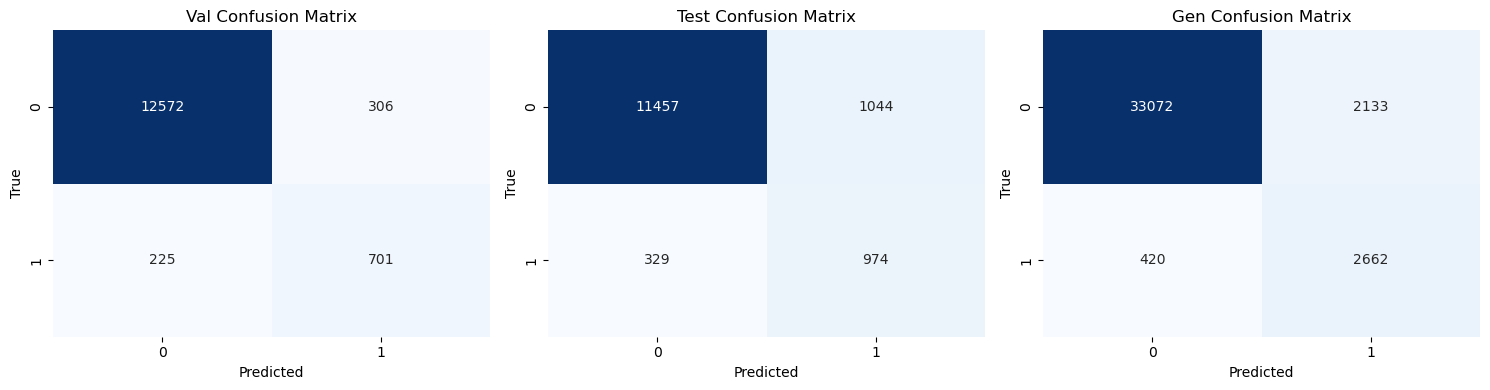

In [11]:
# =========================
# 9 - Confusion Matrices (Calibrated + MC Dropout)
# =========================
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions_mc = {
    "Val":  (y_val_cls_np,  val_preds_cls),
    "Test": (y_test_cls_np, test_preds_cls),
    "Gen":  (y_gen_cls_np,  gen_preds_cls),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (split, (y_true, y_pred)) in zip(axes, predictions_mc.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"{split} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


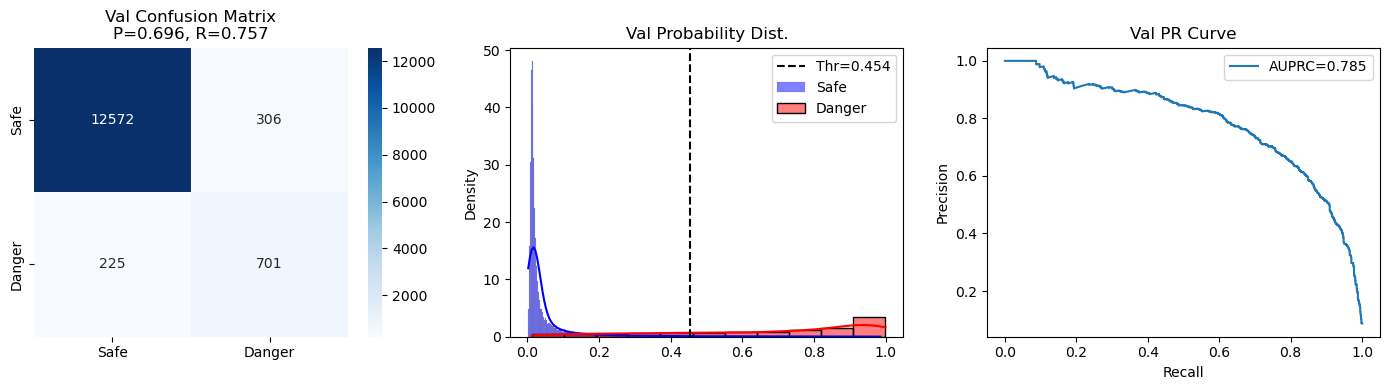


=== Val Classification Report ===
              precision    recall  f1-score   support

        Safe       0.98      0.98      0.98     12878
      Danger       0.70      0.76      0.73       926

    accuracy                           0.96     13804
   macro avg       0.84      0.87      0.85     13804
weighted avg       0.96      0.96      0.96     13804



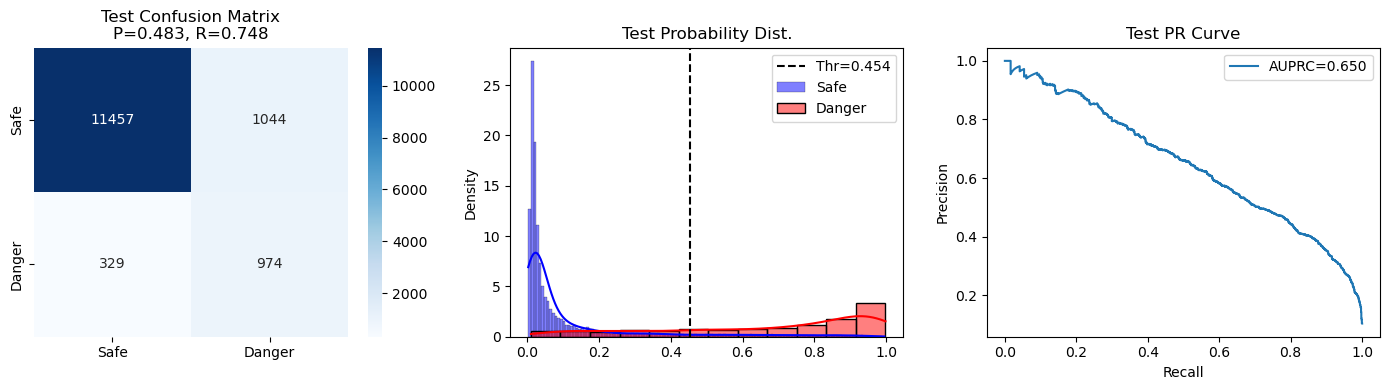


=== Test Classification Report ===
              precision    recall  f1-score   support

        Safe       0.97      0.92      0.94     12501
      Danger       0.48      0.75      0.59      1303

    accuracy                           0.90     13804
   macro avg       0.73      0.83      0.77     13804
weighted avg       0.93      0.90      0.91     13804



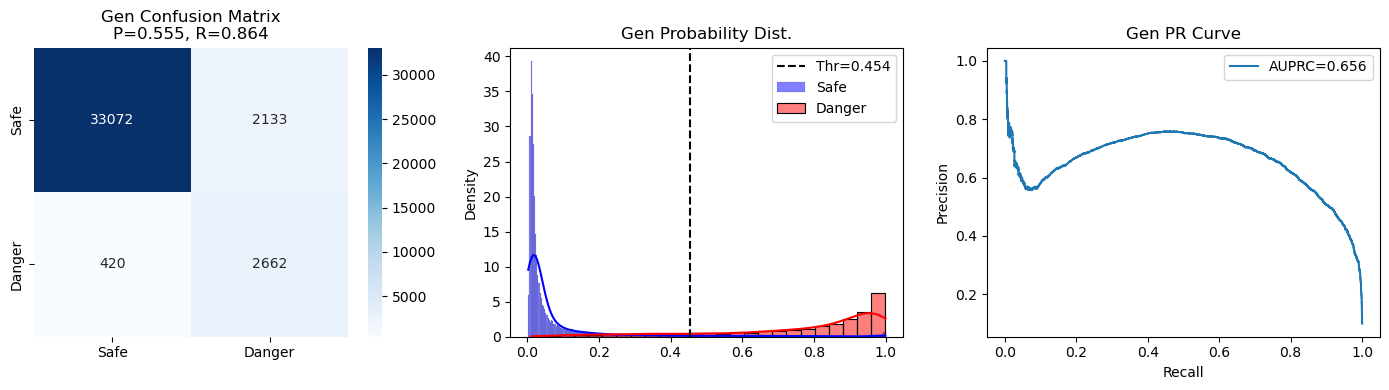


=== Gen Classification Report ===
              precision    recall  f1-score   support

        Safe       0.99      0.94      0.96     35205
      Danger       0.56      0.86      0.68      3082

    accuracy                           0.93     38287
   macro avg       0.77      0.90      0.82     38287
weighted avg       0.95      0.93      0.94     38287



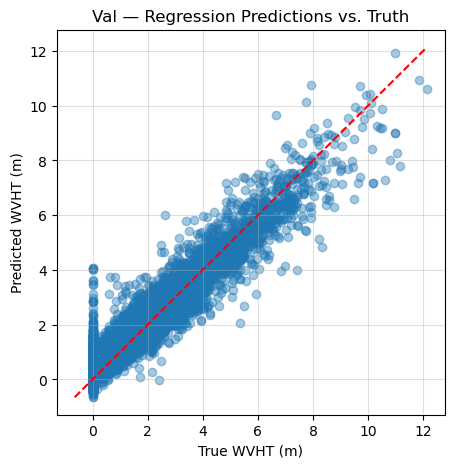

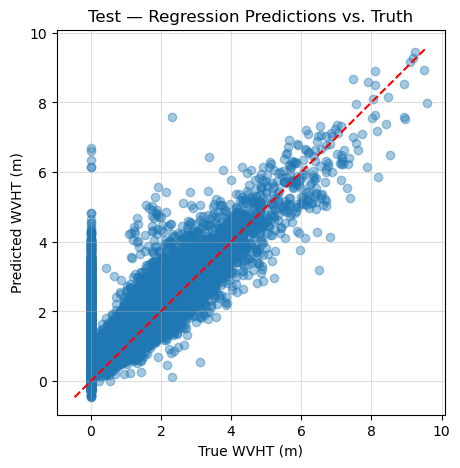

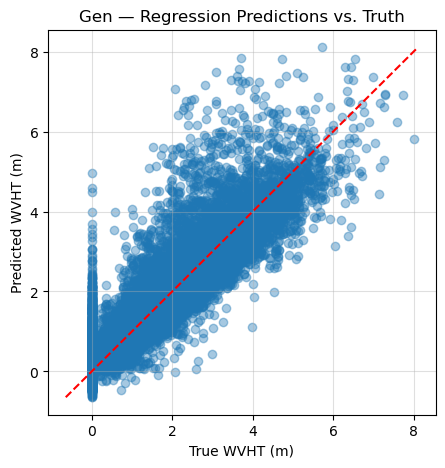

In [13]:
# =========================
# 10 - Confusion Matrices, PR Curves, Prob Distributions, Regression Plots, Class Reports
# =========================
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, classification_report, precision_score, recall_score
import seaborn as sns

# --- Package all splits into a dict ---
splits_data = {
    "Val":  {"true": y_val_cls_np,  "probs": val_probs},
    "Test": {"true": y_test_cls_np, "probs": test_probs},
    "Gen":  {"true": y_gen_cls_np,  "probs": gen_probs}
}

# Validation-derived threshold for all splits
thr = best_thr

for split, res in splits_data.items():
    y_true = np.array(res["true"])
    probs = np.array(res["probs"])
    y_pred = (probs >= thr).astype(int)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Safe", "Danger"], yticklabels=["Safe", "Danger"])
    plt.title(f"{split} Confusion Matrix\nP={precision_score(y_true, y_pred):.3f}, R={recall_score(y_true, y_pred):.3f}")

    # --- Probability Distribution ---
    plt.subplot(1, 3, 2)
    sns.histplot(probs[y_true == 0], color="blue", label="Safe", kde=True, stat="density")
    sns.histplot(probs[y_true == 1], color="red", label="Danger", kde=True, stat="density")
    plt.axvline(thr, color="black", linestyle="--", label=f"Thr={thr:.3f}")
    plt.title(f"{split} Probability Dist.")
    plt.legend()

    # --- PR Curve ---
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    plt.plot(recall, precision, label=f"AUPRC={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{split} PR Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Classification Report ---
    print(f"\n=== {split} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=["Safe", "Danger"]))


# =========================
# Regression Scatter Plots
# =========================
for split, loader in [("Val", val_loader), ("Test", test_loader), ("Gen", gen_loader)]:
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for xb, _, yb_reg in loader:
            xb = xb.to(DEVICE)
            _, preds_reg = model(xb)
            y_true_all.extend(yb_reg.numpy())
            y_pred_all.extend(preds_reg.cpu().numpy())

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_all, y_pred_all, alpha=0.4)
    min_val = min(y_true_all.min(), y_pred_all.min())
    max_val = max(y_true_all.max(), y_pred_all.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("True WVHT (m)")
    plt.ylabel("Predicted WVHT (m)")
    plt.title(f"{split} — Regression Predictions vs. Truth")
    plt.grid(True, alpha=0.4)
    plt.show()


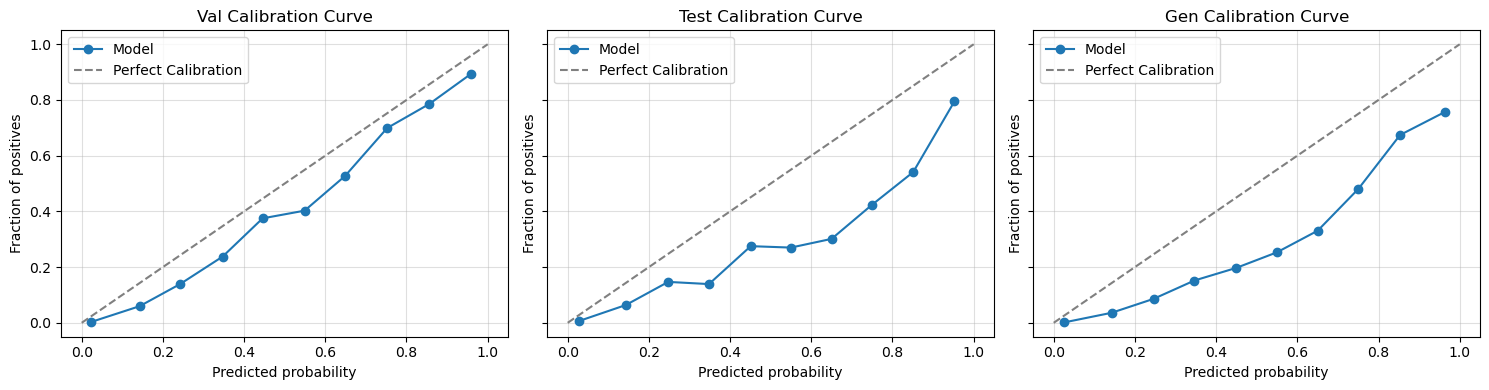

In [14]:
# =========================
# 11 - Calibration Curves (Calibrated + MC Dropout)
# =========================
from sklearn.calibration import calibration_curve

splits_probs = {
    "Val":  (y_val_cls_np,  val_probs),
    "Test": (y_test_cls_np, test_probs),
    "Gen":  (y_gen_cls_np,  gen_probs),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, (split, (y_true, probs)) in zip(axes, splits_probs.items()):
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label='Model')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    ax.set_title(f"{split} Calibration Curve")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.legend()
    ax.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()


In [15]:
# =========================
# Brier Score for Probability Calibration
# =========================
from sklearn.metrics import brier_score_loss

brier_results = {}
for split, (y_true, probs) in {
    "Val":  (y_val_cls_np,  val_probs),
    "Test": (y_test_cls_np, test_probs),
    "Gen":  (y_gen_cls_np,  gen_probs),
}.items():
    brier = brier_score_loss(y_true, probs)
    brier_results[split] = brier
    print(f"{split} Brier Score = {brier:.4f}")


Val Brier Score = 0.0288
Test Brier Score = 0.0655
Gen Brier Score = 0.0469


Calculating permutation importance:  60%|██████████████████████████▏                 | 28/47 [06:48<03:56, 12.45s/feat]C:\Users\pesic\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Calculating permutation importance: 100%|████████████████████████████████████████████| 47/47 [09:04<00:00, 11.58s/feat]



Top 10 features by relative importance:
F14 — AUC drop: 0.1233 (100.0% of max)
F3 — AUC drop: 0.1089 (88.3% of max)
F18 — AUC drop: 0.0425 (34.5% of max)
F39 — AUC drop: 0.0402 (32.6% of max)
F29 — AUC drop: 0.0371 (30.1% of max)
F35 — AUC drop: 0.0273 (22.1% of max)
F40 — AUC drop: 0.0241 (19.5% of max)
F33 — AUC drop: 0.0227 (18.4% of max)
F31 — AUC drop: 0.0221 (18.0% of max)
F19 — AUC drop: 0.0220 (17.8% of max)


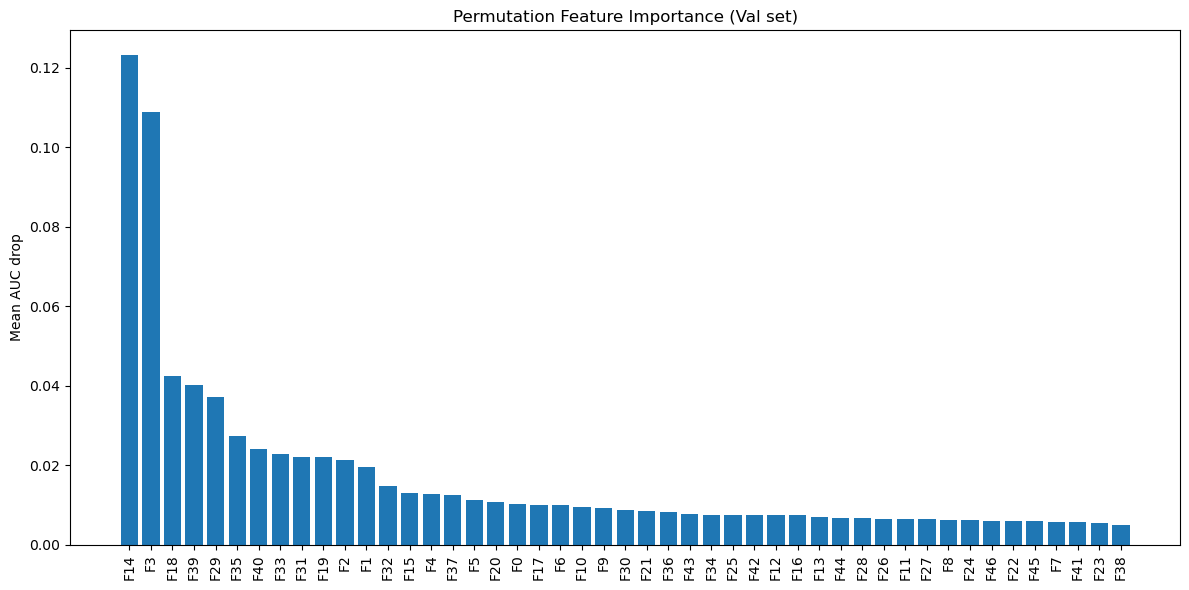

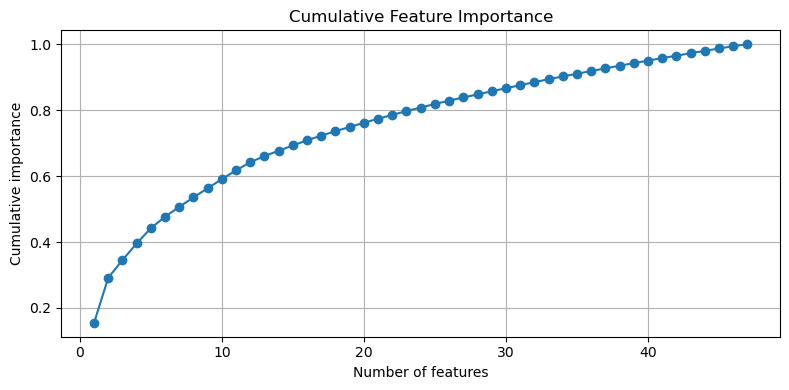

In [19]:
# =========================
# 12 - Parallelized Permutation Feature Importance (Classification)
# =========================
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing

# Generic feature names: F0, F1, ..., Fn
feature_names = [f"F{i}" for i in range(X_val.shape[2])]

# Ensure data is on CPU for permutation
X_is_tensor = torch.is_tensor(X_val)
if X_is_tensor:
    X_val_cpu = X_val.cpu()
else:
    X_val_cpu = X_val.copy()

# Function to compute importance for a single feature
def permute_feature(feat_idx, X, y, baseline_auc, repeats=3):
    drop_auc = []
    for _ in range(repeats):
        if torch.is_tensor(X):
            X_permuted = X.clone()
            idx = torch.randperm(X_permuted.shape[0])
            X_permuted[:, :, feat_idx] = X_permuted[idx, :, feat_idx]
            with torch.no_grad():
                probs, _ = model(X.to(DEVICE) if feat_idx == -1 else X_permuted.to(DEVICE))
                probs = torch.sigmoid(probs).cpu().numpy()
        else:
            X_permuted = X.copy()
            idx = np.random.permutation(X_permuted.shape[0])
            X_permuted[:, :, feat_idx] = X_permuted[idx, :, feat_idx]
            with torch.no_grad():
                probs, _ = model(torch.tensor(X_permuted, dtype=torch.float32).to(DEVICE))
                probs = torch.sigmoid(probs).cpu().numpy()
        drop_auc.append(baseline_auc - roc_auc_score(y, probs))
    return np.mean(drop_auc)

# Compute baseline AUC
baseline_auc_val = roc_auc_score(y_val_cls_np, val_probs)

# Parallel execution
n_jobs = max(1, multiprocessing.cpu_count() - 1)  # leave 1 core free
feat_importances = Parallel(n_jobs=n_jobs)(
    delayed(permute_feature)(feat, X_val_cpu, y_val_cls_np, baseline_auc_val, repeats=3)
    for feat in tqdm(range(X_val.shape[2]), desc="Calculating permutation importance", unit="feat")
)
feat_importances = np.array(feat_importances)

# Sort and normalize
sorted_idx = np.argsort(feat_importances)[::-1]
normalized_importances = feat_importances / feat_importances.max()

# Print top 10 features for reporting
print("\nTop 10 features by relative importance:")
for i in range(min(10, len(feature_names))):
    idx = sorted_idx[i]
    print(f"{feature_names[idx]} — AUC drop: {feat_importances[idx]:.4f} ({normalized_importances[idx]*100:.1f}% of max)")

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(feat_importances)), feat_importances[sorted_idx])
plt.xticks(range(len(feat_importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.ylabel("Mean AUC drop")
plt.title("Permutation Feature Importance (Val set)")
plt.tight_layout()
plt.show()

# Cumulative importance plot
cum_importance = np.cumsum(feat_importances[sorted_idx]) / np.sum(feat_importances)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_importance)+1), cum_importance, marker='o')
plt.xlabel("Number of features")
plt.ylabel("Cumulative importance")
plt.title("Cumulative Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# =========================
# Permutation Feature Importance (Gen set)
# =========================
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# Fraction of Gen set to use
sample_frac = 0.2
sample_size = int(X_gen.shape[0] * sample_frac)
sample_idx = np.random.choice(X_gen.shape[0], size=sample_size, replace=False)

# Sampled data
if torch.is_tensor(X_gen):
    X_gen_sample = X_gen[sample_idx]
else:
    X_gen_sample = X_gen[sample_idx]
y_gen_sample = y_gen_cls_np[sample_idx]
gen_probs_sample = gen_probs[sample_idx]

# Baseline AUC on sampled Gen set
baseline_auc_gen = roc_auc_score(y_gen_sample, gen_probs_sample)

# Sequential loop for low memory usage
feat_importances_gen = []
for feat in tqdm(range(X_gen.shape[2]), desc="Calculating permutation importance (Gen set, sampled)", unit="feat"):
    feat_importances_gen.append(
        permute_feature(feat, X_gen_sample, y_gen_sample, baseline_auc_gen, repeats=2)
    )

feat_importances_gen = np.array(feat_importances_gen)

# Sort and normalize
sorted_idx_gen = np.argsort(feat_importances_gen)[::-1]
normalized_importances_gen = feat_importances_gen / feat_importances_gen.max()

# Print top 5 features for reporting
print("\nTop 5 features by relative importance (Gen set, sampled):")
for i in range(5):
    idx = sorted_idx_gen[i]
    print(f"{feature_names[idx]} — AUC drop: {feat_importances_gen[idx]:.4f} ({normalized_importances_gen[idx]*100:.1f}% of max)")



Calculating permutation importance (Gen set, sampled):   0%|                                  | 0/47 [00:00<?, ?feat/s]
Calculating permutation importance (Gen set, sampled):   2%|▌                         | 1/47 [00:03<02:19,  3.03s/feat]
Calculating permutation importance (Gen set, sampled):   4%|█                         | 2/47 [00:05<02:10,  2.90s/feat]
Calculating permutation importance (Gen set, sampled):   6%|█▋                        | 3/47 [00:08<02:06,  2.87s/feat]
Calculating permutation importance (Gen set, sampled):   9%|██▏                       | 4/47 [00:11<01:59,  2.78s/feat]
Calculating permutation importance (Gen set, sampled):  11%|██▊                       | 5/47 [00:14<01:58,  2.82s/feat]
Calculating permutation importance (Gen set, sampled):  13%|███▎                      | 6/47 [00:16<01:53,  2.77s/feat]
Calculating permutation importance (Gen set, sampled):  15%|███▊                      | 7/47 [00:19<01:51,  2.80s/feat]
Calculating permutation importance (Gen


Top 5 features by relative importance (Gen set, sampled):
F14 — AUC drop: 0.2112 (100.0% of max)
F18 — AUC drop: 0.0226 (10.7% of max)
F33 — AUC drop: 0.0198 (9.4% of max)
F3 — AUC drop: 0.0195 (9.2% of max)
F32 — AUC drop: 0.0194 (9.2% of max)
